In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cosmodc2 as extract_cosmodc2
import lens_data as lens
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import mysql

from mysql.connector import Error
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)

# Lens catalog

In [2]:
lens_catalog = lens.lens_catalog
index = 10

## Cosmodc2 with qserv & GCRCatalogs

In [3]:
#z, ra, dec = lens_catalog['redshift'][index], lens_catalog['ra'][index], lens_catalog['dec'][index]
z, ra, dec = .01, 65, -40

### true shapes, true redshifts

In [4]:
def query(lens_z, lens_distance, ra, dec, rmax = 10):
    r"""
    Attributes:
    -----------
    z: float
        lens redshift
    ra: float
        lens right ascension
    dec: float
        lens declinaison
    rmax: float
        maximum radius
    """
    zmax = 3.
    zmin = 0.05
    theta_max = (rmax/lens_distance) * (180./np.pi)
    query = "SELECT data.coord_ra as ra, data.coord_dec as dec, data.redshift as z, "
    query += "data.galaxy_id as galaxy_id, "
    query += "data.mag_i, data.mag_r, data.mag_y, "
    query += "data.shear_1 as shear1, data.shear_2 as shear2, data.convergence as kappa, "
    query += "data.ellipticity_1_true as e1_true, data.ellipticity_2_true as e2_true " 
    query += "FROM cosmoDC2_v1_1_4_image.data as data "
    query += f"WHERE data.redshift >= {zmin} AND data.redshift < {zmax} "
    query += f"AND scisql_s2PtInCircle(coord_ra, coord_dec, {ra}, {dec}, {theta_max}) = 1 "
    query += f"AND data.mag_i <= 28 "
    query += ";" 
    return query

In [15]:
rmax=.1
bckgd_galaxy_catalog = extract_cosmodc2.extract(lens_redshift = z, lens_ra = ra, lens_dec = dec, rmax=rmax, 
                                                query=query(z, cosmo.eval_da(z), ra, dec, rmax = rmax),
                                                conn_qserv=conn, cosmo=cosmo)

In [16]:
cl = bckgd_galaxy_catalog 

In [17]:
len(cl.galcat)

82940

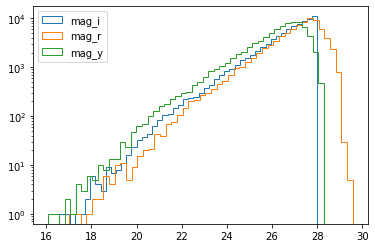

In [18]:
bins=50
plt.hist(cl.galcat['mag_i'], bins=bins, histtype='step', label='mag_i')
plt.hist(cl.galcat['mag_r'], bins=bins, histtype='step', label='mag_r')
plt.hist(cl.galcat['mag_y'], bins=bins, histtype='step', label='mag_y')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

In [19]:
theta_arcmin = 3437.75*(rmax/cosmo.eval_da_z1z2(0, z))
S_arcmin2 =np.pi*theta_arcmin**2

In [20]:
mag_i_max=np.linspace(23, 25, 20)

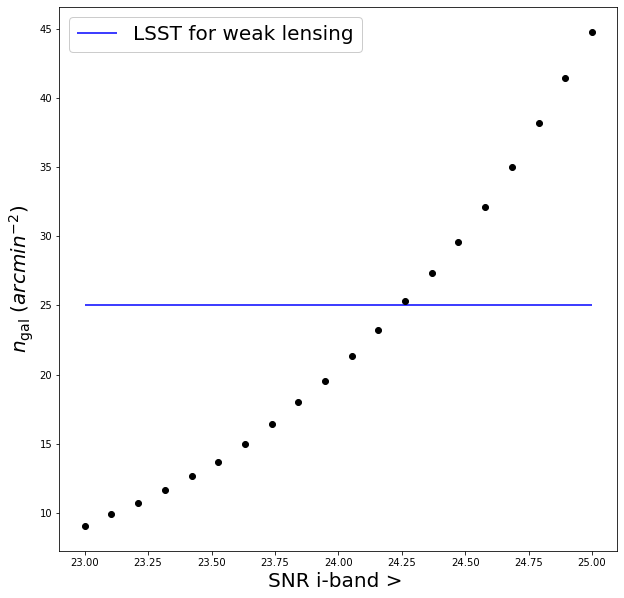

In [29]:
plt.figure(figsize=(10,10))
plt.hlines(25, mag_i_max[0], mag_i_max[-1], color='b', label='LSST for weak lensing')
for i,mag_i_min_ in enumerate(mag_i_max):
    mask=(cl.galcat['mag_i'] < mag_i_min_)
    mask = mask * (cl.galcat['mag_r'] < 28)
    n_gal_arcmin2=len(cl.galcat[mask])/S_arcmin2
    plt.plot(mag_i_min_, n_gal_arcmin2 ,'o', color='k')

plt.xlabel(r'SNR i-band > ', fontsize=20)
plt.ylabel(r'$n_{\rm gal}$ $(arcmin^{-2})$', fontsize=20)
plt.legend(framealpha=1, fontsize=20)